In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision

# dataset and transformation
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
# https://pytorch.org/vision/stable/datasets.html#stl10

In [4]:
# specify the data path
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_data = datasets.CIFAR10(path2data, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(path2data, train=False, download=True, transform=transforms.ToTensor())

print(len(train_data))
print(len(test_data))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
10000


In [5]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_data]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_data]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_data]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_data]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])

test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(test_meanR, test_meanG, test_meanB)

0.49139965 0.48215845 0.4465309
0.49421427 0.48513138 0.45040908


In [6]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224, interpolation=2),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomCrop(32, padding=4),
])

test_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224, interpolation=2),
                        transforms.Normalize([test_meanR, test_meanG, test_meanB],[test_stdR, test_stdG, test_stdB]),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [7]:
BATCH_SIZE = 40

In [8]:
# apply transforamtion
train_data.transform = train_transformation
test_data.transform = test_transformation

# create DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {'train' : train_loader, 'test' : test_loader }
dataset_sizes = { 'train' : len(train_data) , 'test' : len(test_data) }

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(class_names)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck horse plane   car   car  deer truck  bird   car   cat  bird  ship  deer   dog  deer  bird plane   cat horse  deer plane   dog  ship  bird   car  bird   cat   cat  bird   car  bird  bird truck  ship truck  frog  bird  deer   cat  ship


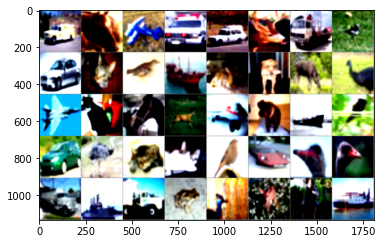

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(tf.size(images))
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(BATCH_SIZE)))
plt.show()

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 224, 224))
    print(y.size())

test()

torch.Size([1, 10])


In [15]:
model = ResNet18().to(DEVICE)

In [16]:
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10).cuda()

# model = model.to(DEVICE)

In [17]:
summary(model, (3, 224, 224), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
        BasicBlock-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [18]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


print('================Finished modeling')

================Finished modeling


In [20]:
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.3758 Acc: 0.4980
test Loss: 1.0418 Acc: 0.6321

Epoch 1/19
----------
train Loss: 0.8677 Acc: 0.6953
test Loss: 0.7605 Acc: 0.7356

Epoch 2/19
----------
train Loss: 0.6366 Acc: 0.7811
test Loss: 0.6471 Acc: 0.7798

Epoch 3/19
----------
train Loss: 0.5141 Acc: 0.8210
test Loss: 0.6279 Acc: 0.7813

Epoch 4/19
----------
train Loss: 0.4205 Acc: 0.8543
test Loss: 0.5772 Acc: 0.8045

Epoch 5/19
----------
train Loss: 0.3491 Acc: 0.8790
test Loss: 0.5442 Acc: 0.8197

Epoch 6/19
----------
train Loss: 0.2886 Acc: 0.9007
test Loss: 0.5294 Acc: 0.8205

Epoch 7/19
----------
train Loss: 0.1595 Acc: 0.9511
test Loss: 0.3952 Acc: 0.8666

Epoch 8/19
----------
train Loss: 0.1285 Acc: 0.9622
test Loss: 0.3921 Acc: 0.8703

Epoch 9/19
----------
train Loss: 0.1105 Acc: 0.9694
test Loss: 0.3917 Acc: 0.8702

Epoch 10/19
----------
train Loss: 0.0957 Acc: 0.9754
test Loss: 0.3989 Acc: 0.8691

Epoch 11/19
----------
train Loss: 0.0844 Acc: 0.9784
test Loss: 0.4010 Acc

In [23]:
# Save model
torch.save(model, 'myresnet18_model.pt')

In [24]:
# Load model
model = torch.load('myresnet18_model.pt')

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


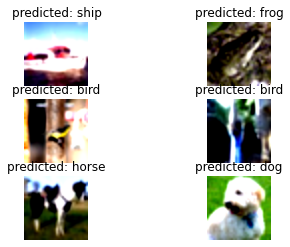

In [33]:
visualize_model(model)